In [2]:
import os
os.environ['HANLP_HOME'] = '/dlabscratch1/tdai/hanlp'
import hanlp
import chinese_converter
import random
import re
from tqdm import tqdm
import math
from collections import defaultdict
import hanlp.utils
import pandas as pd
from collections import Counter

In [141]:
MALE_SEED = ['哥', '弟', '父', '爸', '爷', '伯', '叔', '舅', '公', '男', '郎', '兄']
FEMALE_SEED = ['姐', '妹', '母', '妈', '奶', '婆', '嬷', '女', '娘',  '姨', '嫂', '姊']

MALE_WORDS = ["他", "他们", "男士", "男孩", "男子", "男性", "先生", "男人", "爸爸", "父亲", "姥爷", "儿子", "男友",\
    "叔叔", "哥哥", "弟弟", "爷爷", "外公", "公公", "舅舅", "伯伯", "大哥", "小弟", "男神", "男生",\
    "阿公", "爸比", "父親", "祖父", "外祖父", "堂哥", "堂弟", "表哥", "表弟", '大哥', '阿公', '兄弟']
FEMALE_WORDS = ["她", "她们", "女士", "女孩", "女子", "女性", "小姐", "女人", "妈妈", "母亲", "姥姥", "女儿", "女友",\
    "阿姨", "姐姐", "妹妹", "奶奶", "外婆", "婆婆", "舅妈", "大姐", "小妹", "女神", "女生",\
    "阿嬷", "妈咪", "母親", "祖母", "外祖母", "堂姐", "堂妹", "表姐", "表妹", '小姐', '太太', '阿姨', '姊妹']

In [142]:
# collect text
book_names = [f.encode('latin1').decode('utf-8') for f in os.listdir('./book')]
text = ""
for book in book_names:
    if "朱天心" in book:
        book = book.encode('utf-8').decode('latin1')
        with open(f'./book/{book}', 'r', encoding='utf-8') as f:
                text_ = f.read()
                text_ = chinese_converter.to_simplified(text_)
                text += text_ + "\n"

In [143]:
# clean the text
text_chunks = text.replace("\u3000", "").split("\n")
text_chunks = [chunk for chunk in text_chunks if chunk.strip()]
text_chunks = [chunk for text_chunk in text_chunks for chunk in hanlp.utils.rules.split_sentence(text_chunk)]
text_chunks = [chunk for chunk in text_chunks if re.search(r'[\u4e00-\u9fff]', chunk)]

ways of finding person entities (pronoun, person name, etc.) for better dependency parsing analysis (still exploring)

In [6]:
# explan gender words
male_counter = Counter()
female_counter = Counter()

pattern = re.compile(r"[一-龥]{1,4}")

words = pattern.findall("。".join(text_chunks))

for word in words:
    if any(p in word for p in MALE_SEED):
        male_counter[word] += 1
    if any(p in word for p in FEMALE_SEED):
        female_counter[word] += 1

# 获取频率较高的称谓词
top_male = [w for w, c in male_counter.most_common(50) if len(w) <= 3]
top_female = [w for w, c in female_counter.most_common(50) if len(w) <= 3]

print(top_male)
print(top_female)

['男孩', '爷爷说', '哥', '爸爸', '男人', '公园', '爸', '男孩子', '个男孩', '哥哥', '教父', '舅妈', '父亲', '公园号', '父', '国父', '天父', '伯', '外公', '公室', '男友', '少爷', '我舅妈', '男子', '阿义哥', '弟', '父字']
['女孩', '妈妈', '母', '妹妹', '的女孩', '女', '婆', '的女人', '舅妈', '妈', '妹', '母亲', '女人', '姊姊', '姊', '的女儿', '我舅妈', '我老婆', '小姐', '妹们', '是女', '妹妹说']


In [151]:
# expand using information from constituents and NER
HanLP = hanlp.pipeline() \
    .append(hanlp.load('COARSE_ELECTRA_SMALL_ZH'), output_key='tok') \
    .append(hanlp.load('CTB9_POS_ELECTRA_SMALL'), output_key='pos') \
    .append(hanlp.load('MSRA_NER_ELECTRA_SMALL_ZH'), output_key='ner', input_key='tok') \
    .append(hanlp.load('CTB9_CON_ELECTRA_SMALL'), output_key='con', input_key='tok')\
    # .append(hanlp.load('CTB9_DEP_ELECTRA_SMALL', conll=0), output_key='dep', input_key='tok')\
    # .append(hanlp.load('CTB9_CON_ELECTRA_SMALL'), output_key='con', input_key='tok')


all_records = []
for text_sample in tqdm(text_chunks):
    if "魏哥哥" in text_sample:
        HanLP(text_sample).pretty_print()
        res = HanLP(text_sample)
        # print(res)
        # print(res['con'])
        break

  0%|          | 0/5317 [00:00<?, ?it/s]     

 81%|████████▏ | 4325/5317 [00:00<00:00, 23211.79it/s]


customize the tokenzier with new words

In [148]:
MALE_WORDS_EXPANDED = [
    '卢伯伯', '男孩子', '外公', '我大舅', '兄弟们', '先生', '男朋友', '教父', 
    '男人', '先生们', '乔和魏哥哥', '我外公'
]

FEMALE_WORDS_EXPANDED = ['我老婆', '孟姊姊', '女孩子', '我外婆', '女孩儿',
                         '女人', '女', '小女', '妈妈', '姊姊', '妹妹', '阿芳嫂', '女学生']

In [149]:
MALE_WORDS = set(MALE_WORDS).union(MALE_WORDS_EXPANDED)
FEMALE_WORDS = set(FEMALE_WORDS).union(FEMALE_WORDS_EXPANDED)
CUSTOMIZED_WORDS = MALE_WORDS.union(FEMALE_WORDS)

tokenzier_name = 'COARSE_ELECTRA_SMALL_ZH'
tokenizer = hanlp.load(tokenzier_name)
tokenizer.dict_force = None
tokenizer.dict_combine = CUSTOMIZED_WORDS

compute idf with the tokenizer

In [150]:
# compute idf
doc_freq = defaultdict(int)
total_docs = len(text_chunks)
for doc in tqdm(text_chunks, desc="Tokenizing documents"):
    tokens = set(tokenizer(doc))  # use a set to count each token once per document
    for token in tokens:
        doc_freq[token] += 1
idf = {token: math.log((total_docs + 1) / (freq + 1)) + 1 for token, freq in doc_freq.items()}
with open('token_idf.txt', 'w', encoding='utf-8') as f:
    for token, score in idf.items():
        f.write(f"{token}\t{score}\n")

Tokenizing documents: 100%|██████████| 5317/5317 [01:19<00:00, 66.64it/s]


perform dependency parsing

In [153]:
HanLP = hanlp.pipeline() \
    .append(tokenizer, output_key='tok') \
    .append(hanlp.load('CTB9_DEP_ELECTRA_SMALL', conll=0), output_key='dep', input_key='tok')\

def extract_verbs(toks, dep):
    records = []
    for i, tok in enumerate(toks):
        if tok in MALE_WORDS:
            records.append((tok, toks[dep[i][0]-1], dep[i][1], 'male'))
        elif tok in FEMALE_WORDS:
            records.append((tok, toks[dep[i][0]-1], dep[i][1], 'female'))
    return records

all_records = []
for text_sample in tqdm(text_chunks, desc="Processing text with HanLP"):
    res = HanLP(text_sample)
    all_records.extend(extract_verbs(res['tok'], res['dep']))

df_gender = pd.DataFrame(all_records, columns=['gender_word', 'verb', 'relation', 'gender'])
df_gender.to_csv('gender_coarse.csv')

Processing text with HanLP: 100%|██████████| 5317/5317 [05:53<00:00, 15.05it/s]


In [163]:
import pandas as pd
from matplotlib import font_manager
import matplotlib.pyplot as plt
from matplotlib import rcParams


plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号
print("SimHei" in [f.name for f in font_manager.fontManager.ttflist])  

# df_gender = pd.read_csv('gender_coarse.csv').drop(columns=['Unnamed: 0'])
# idf_df = pd.read_csv('token_idf.txt', sep='\t', header=None, names=['token', 'idf'], encoding='utf-8')
# idf = idf_df.set_index('token')['idf'].to_dict()

True


In [ ]:
def ranking(group):
    verb_counts = group['verb'].value_counts()
    scores = {verb: count * idf.get(verb, 1) for verb, count in verb_counts.items()}
    ranked_verbs = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return pd.DataFrame({'verb_ranked': [verb for verb, score in ranked_verbs],
                        'count': [verb_counts[verb] for verb, score in ranked_verbs],
                        'idf': [idf.get(verb, 1) for verb, score in ranked_verbs]})

df_group = df_gender.groupby(['gender', 'relation']).apply(ranking)

/tmp/ipykernel_2545460/1916594008.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_group = df_gender.groupby(['gender', 'relation']).apply(ranking)


In [165]:
df_group

verb_ranked  count       idf
gender relation                               
female amod     0          同业      4  6.939795
                1          明星      2  7.632942
                2         漫画家      1  8.885705
                3          机车      1  8.885705
                4          同胞      1  8.192558
...                       ...    ...       ...
male   xsubj    4          回答      1  6.534330
                5           拍      1  6.443358
                6          没有      1  4.189781
                7           做      1  4.073521
                8           看      1  3.315454

[2371 rows x 3 columns]

In [168]:
gender_relation_pair = ('male', 'nsubj')
verbs = df_group.loc[gender_relation_pair][df_group.loc[gender_relation_pair].apply(lambda x: len(x['verb_ranked'])>=2, axis=1)]
verbs

,verb_ranked,count,idf
1,告诉,17,5.004142
10,以为,9,4.993885
11,一样,11,4.081684
12,记得,9,4.953880
14,知道,11,3.958452
...,...,...,...
701,想起,1,5.404465
703,奇怪,1,5.274787
705,眼睛,1,5.196826
706,有些,1,5.196826


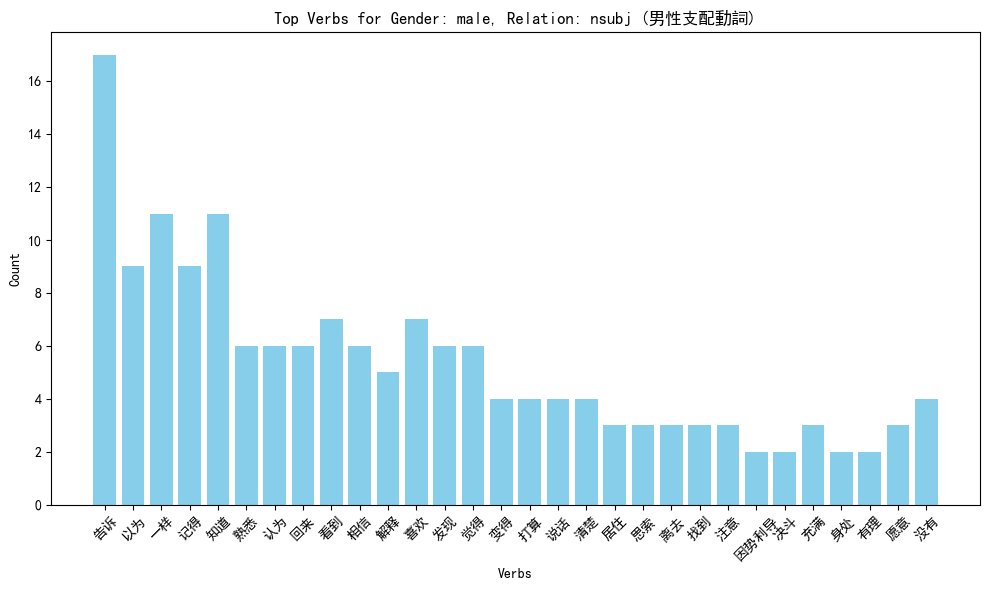

In [171]:
gender_relation_pair = ('male', 'nsubj')
verbs = df_group.loc[gender_relation_pair][df_group.loc[gender_relation_pair].apply(lambda x: len(x['verb_ranked'])>=2, axis=1)].head(30)

plt.figure(figsize=(10, 6))
plt.bar(verbs['verb_ranked'], verbs['count'], color='skyblue')
plt.xlabel('Verbs')
plt.ylabel('Count')
plt.title(f"Top Verbs for Gender: {gender_relation_pair[0]}, Relation: {gender_relation_pair[1]} (男性支配動詞)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

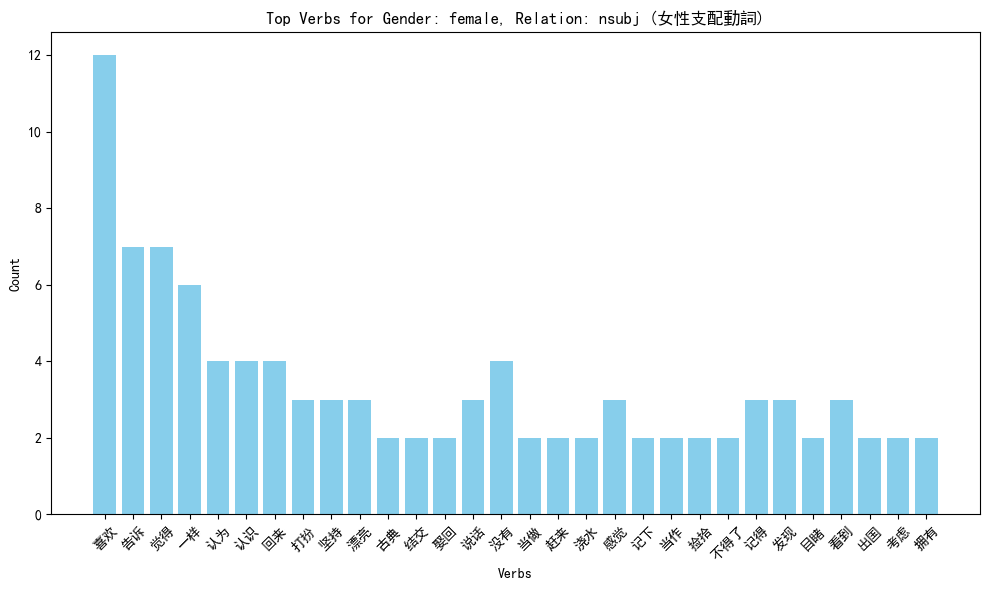

In [172]:
gender_relation_pair = ('female', 'nsubj')
verbs = df_group.loc[gender_relation_pair][df_group.loc[gender_relation_pair].apply(lambda x: len(x['verb_ranked'])>=2, axis=1)].head(30)

plt.figure(figsize=(10, 6))
plt.bar(verbs['verb_ranked'], verbs['count'], color='skyblue')
plt.xlabel('Verbs')
plt.ylabel('Count')
plt.title(f"Top Verbs for Gender: {gender_relation_pair[0]}, Relation: {gender_relation_pair[1]} (女性支配動詞)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

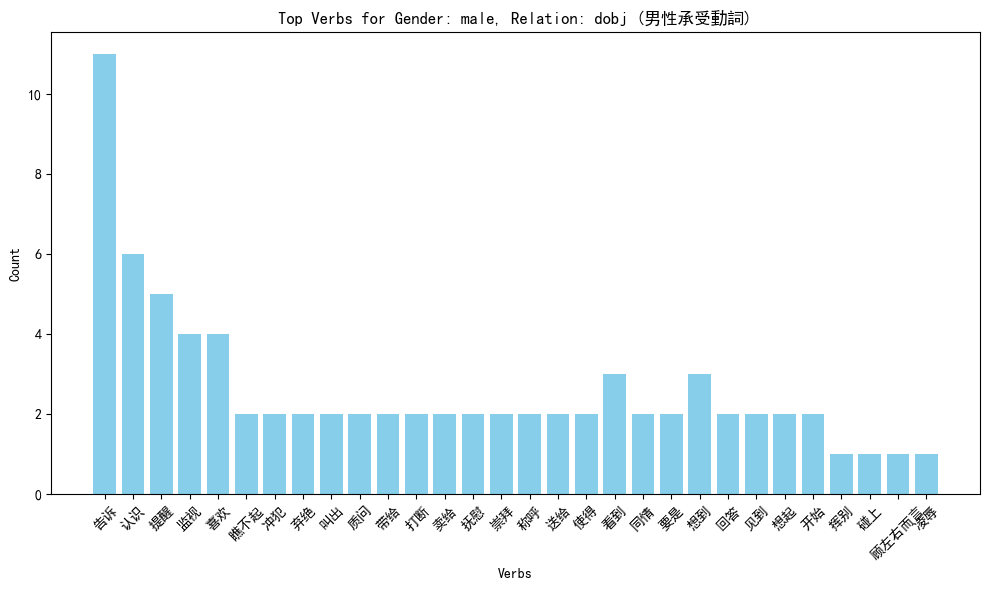

In [174]:
gender_relation_pair = ('male', 'dobj')
verbs = df_group.loc[gender_relation_pair][df_group.loc[gender_relation_pair].apply(lambda x: len(x['verb_ranked'])>=2, axis=1)].head(30)

plt.figure(figsize=(10, 6))
plt.bar(verbs['verb_ranked'], verbs['count'], color='skyblue')
plt.xlabel('Verbs')
plt.ylabel('Count')
plt.title(f"Top Verbs for Gender: {gender_relation_pair[0]}, Relation: {gender_relation_pair[1]} (男性承受動詞)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

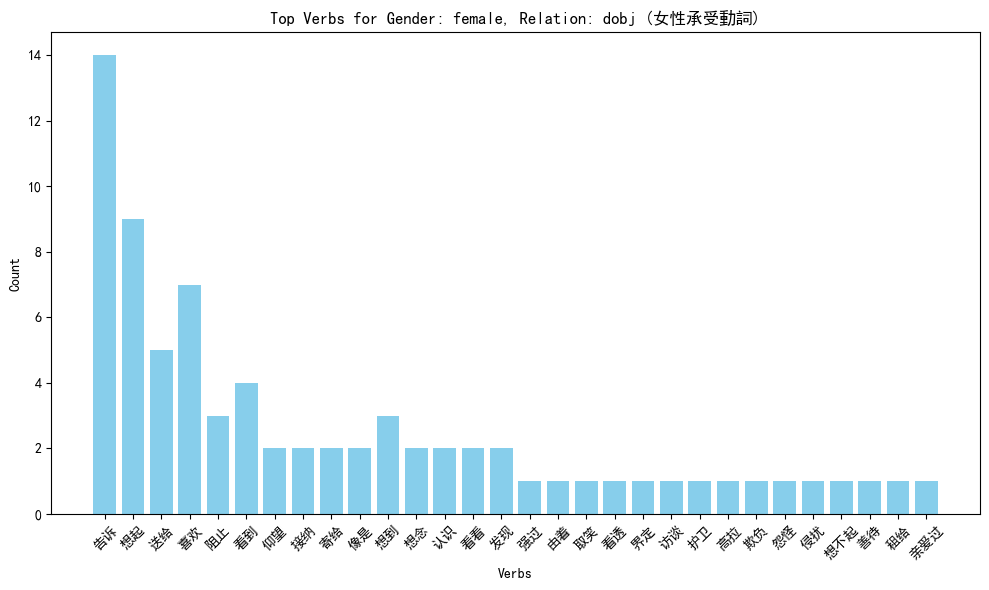

In [173]:
gender_relation_pair = ('female', 'dobj')
verbs = df_group.loc[gender_relation_pair][df_group.loc[gender_relation_pair].apply(lambda x: len(x['verb_ranked'])>=2, axis=1)].head(30)

plt.figure(figsize=(10, 6))
plt.bar(verbs['verb_ranked'], verbs['count'], color='skyblue')
plt.xlabel('Verbs')
plt.ylabel('Count')
plt.title(f"Top Verbs for Gender: {gender_relation_pair[0]}, Relation: {gender_relation_pair[1]} (女性承受動詞)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()